In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gudhi as gd
# from gudhi.tensorflow import RipsLayer
from gudhi.representations import Landscape
# import tensorflow as tf
#import utils as u
import calendar 
from datetime import datetime
import matplotlib.dates as mdates

In [46]:
data = pd.read_csv("cleaned.csv",index_col=0,header=None,skiprows=1)
data = data.iloc[:,1:].iloc[:-31]
print(data.columns)

Index([2], dtype='int64')


In [51]:
dates = []
start = 1
for year in range(2015,2025):
    if calendar.isleap(year):
        days = 366
    else:
        days = 365
    for day in range(1, days+1):
        day = str(day).zfill(3)
        res = datetime.strptime(str(year) + "-" + day, "%Y-%j").strftime("%m-%d-%Y")
        dates.append(res)
data['Date']=dates
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index("Date")
data.rename(columns={2: 'snow'}, inplace=True)




In [52]:
data

,snow
Date,
2015-01-01,0.000386
2015-01-02,0.175324
2015-01-03,1.424501
2015-01-04,1.132926
2015-01-05,2.866150
...,...
2024-12-27,0.078915
2024-12-28,0.122403
2024-12-29,0.162725


In [105]:
year = 2022
data1 = data.loc[f'{year}-08-01' : f'{year+1}-07-31']
window_size = 25
delay = 7

In [106]:
dgms = np.empty(len(data1)-window_size, dtype=object)
for i in range(len(data1)-window_size):
    window = data1['snow'][i:i+window_size].values
    X = np.zeros((window_size-delay, delay), dtype=float)
    for j in range(window_size-delay):
        X[j,:] = window[j:j+delay]

    rc = gd.RipsComplex(points=X).create_simplex_tree(max_dimension=2)  
    rc.persistence()
    dgm = rc.persistence_intervals_in_dimension(1) 
    dgms[i]=dgm 

Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is [-inf, -inf]
First value and second value in range are the same: grid is made of resolution copies of this value
Empty list or empty diagrams: sample range is 

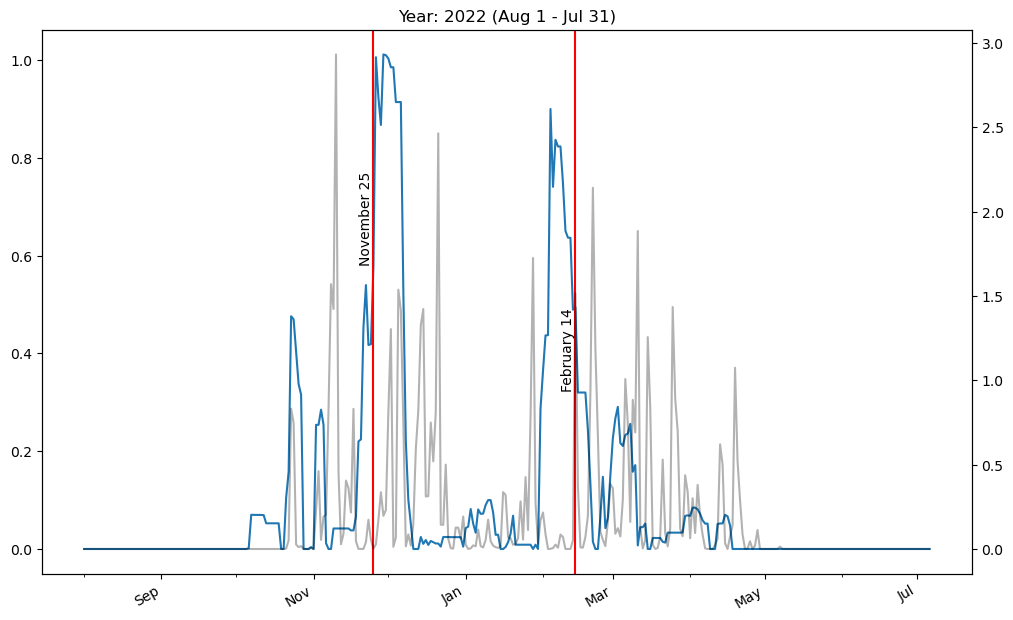

In [109]:
# Adjusting the date range to start from August 1 to July 31 of the next year
data1_aug_jul = data1[(data1.index.month >= 8) | (data1.index.month <= 7)]

norms = np.zeros(dgms.shape[0])
for i in range(dgms.shape[0]):
    l = Landscape(num_landscapes=2, resolution=10).fit_transform([dgms[i]])
    norms[i] = np.linalg.norm(l[0])

month_locator = mdates.MonthLocator()
fig, ax = plt.subplots(figsize=(12, 8))
month_year_formatter = mdates.DateFormatter('%b')
ax.xaxis.set_minor_locator(month_locator)
ax.xaxis.set_major_formatter(month_year_formatter)
ax.plot(data1_aug_jul.index[:-window_size], norms)

# Update title to reflect the new year range
ax.set_title(f'Year: {year} (Aug 1 - Jul 31)')

ax2 = ax.twinx()
ax2.plot(data1_aug_jul.index[:-window_size], data1_aug_jul['snow'][:-window_size], c='k', alpha=0.3)

fig.autofmt_xdate()

# Update the prediction for onset and withdrawal within the new date range
pred_onset = data1_aug_jul.iloc[np.where((norms > norms.mean() + 2 * norms.std()))[0][0]].name
ax.axvline(pred_onset, c='r')
# Move the text closer to the red line to prevent excessive whitespace
ax.text(pred_onset, norms[np.where((norms > norms.mean() + 2 * norms.std()))[0][0]], 
        pred_onset.strftime('%B %d'), rotation=90, verticalalignment='bottom', horizontalalignment='right')

pred_withdraw = data1_aug_jul.iloc[np.where((norms > norms.mean() + 1 * norms.std()))[0][-1]].name
ax.axvline(pred_withdraw, c='r')
# Adjusting the text positioning for withdrawal similarly
ax.text(pred_withdraw, norms[np.where((norms > norms.mean() + 1 * norms.std()))[0][-1]], 
        pred_withdraw.strftime('%B %d'), rotation=90, verticalalignment='top', horizontalalignment='right')

plt.show()


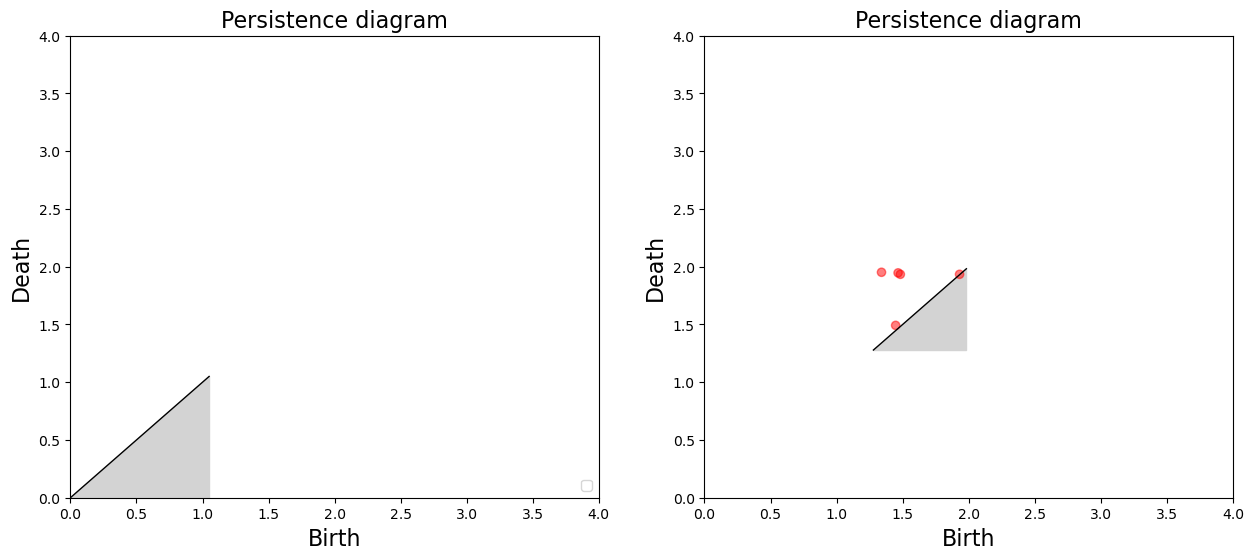

In [108]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
gd.plot_persistence_diagram(dgms[0], colormap=[[1,0,0]], alpha=0.5, axes=ax1)
gd.plot_persistence_diagram(dgms[np.where(norms > norms.mean()  + 3 * norms.std() )[0][0]], colormap=[[1,0,0]], alpha=0.5, axes=ax2)

for a in [ax1,ax2]:
    a.set_xlim(0,4)
    a.set_ylim(0,4)